In [ ]:
!nvidia-smi

Sat Jul 20 06:25:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

In [ ]:
img_size = 256
batch_size = 16
channels = 3

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/tomato",
    shuffle=True,
    image_size = (img_size , img_size),
    batch_size = batch_size,
    )

Found 8969 files belonging to 6 classes.


In [ ]:
types = dataset.class_names
types

['Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

(-0.5, 255.5, 255.5, -0.5)

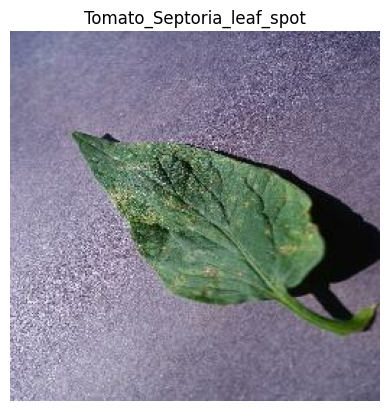

In [ ]:
for img_batch, label_batch in dataset.take(1):
  img = img_batch[0].numpy().astype('uint8')
  label = label_batch[0].numpy()

plt.title(types[label])
plt.imshow(img)
plt.axis('off')

In [ ]:
len(dataset)

561

In [ ]:
def get_data_partition(ds, train = 0.8, test = 0.1, val = 0.1, shuffle =True, shuffle_size = 10000 ):
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 10)

  data_size = len(dataset)

  train_size = int(train * data_size)
  val_size = int(val * data_size)

  train_ds = dataset.take(train_size)
  val_ds = dataset.skip(train_size).take(val_size)
  test_ds = dataset.skip(train_size).skip(val_size)

  return train_ds, test_ds, val_ds

In [ ]:
train, test, val = get_data_partition(dataset)
print(len(train), len(test), len(val))

448 57 56


In [ ]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(img_size, img_size),
    layers.Rescaling(1.0/255),
])

In [ ]:
train = train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val =  val.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
augm = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(0.2,0.3),
])

In [ ]:
train =  train.map(
    lambda x,y : (augm(x, training = True), y)
).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
n_classes = 6
ip_shp = (batch_size, img_size, img_size, channels)

model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=ip_shp),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=ip_shp)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (16, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (16, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (16, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (16, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train,
    validation_data=val,
    batch_size=batch_size,
    verbose=1,
    epochs=5,
)

Epoch 1/5
448/448 [==============================] - 1319s 514ms/step - loss: 1.3113 - accuracy: 0.4640 - val_loss: 0.9031 - val_accuracy: 0.6429
Epoch 2/5
448/448 [==============================] - 62s 137ms/step - loss: 0.8400 - accuracy: 0.6897 - val_loss: 0.5901 - val_accuracy: 0.7902
Epoch 3/5
448/448 [==============================] - 64s 142ms/step - loss: 0.6906 - accuracy: 0.7522 - val_loss: 0.7188 - val_accuracy: 0.7433
Epoch 4/5
448/448 [==============================] - 62s 138ms/step - loss: 0.5473 - accuracy: 0.8043 - val_loss: 0.8481 - val_accuracy: 0.7355
Epoch 5/5
448/448 [==============================] - 63s 140ms/step - loss: 0.4241 - accuracy: 0.8485 - val_loss: 0.3019 - val_accuracy: 0.8895


In [ ]:
model.save("/content/drive/MyDrive/models/tomatoE5.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.evaluate(test)

57/57 [==============================] - 144s 18ms/step - loss: 0.3246 - accuracy: 0.8740


[0.3246206045150757, 0.8740331530570984]

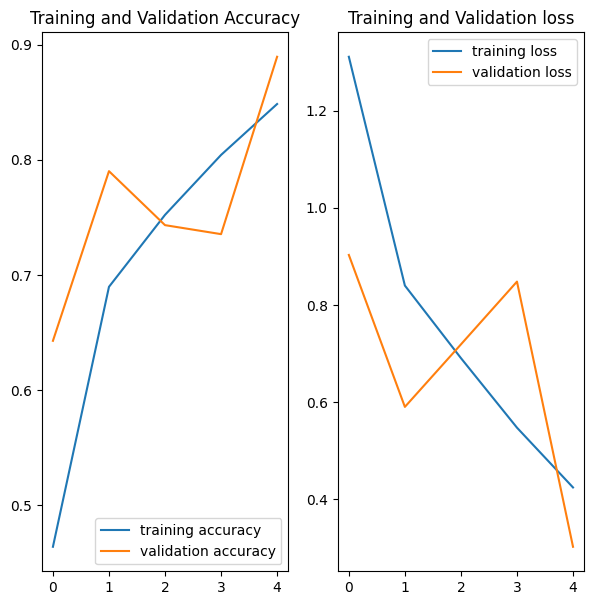

In [ ]:
epochs = 5
plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(range(epochs), acc, label = 'training accuracy')
plt.plot(range(epochs), val_acc, label = 'validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(range(epochs), loss, label= "training loss")
plt.plot(range(epochs), val_loss, label = 'validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

plt.show()

1/1 [==============================] - 0s 25ms/step


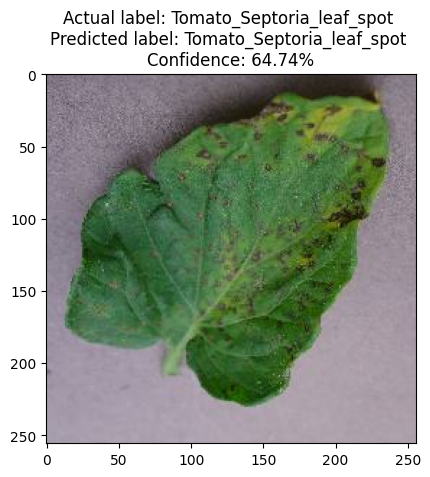

In [ ]:
import numpy as np

for images_batch, labels_batch in test.take(1):
    img, label = images_batch[0].numpy(), labels_batch[0].numpy()
    batch_prediction = model.predict(images_batch)
    confidence = max(batch_prediction[0])
    pos = np.argmax(batch_prediction[0])
    plt.imshow(img.astype('uint8'))
    plt.title(f"Actual label: {types[label]} \nPredicted label: {types[pos]} \nConfidence: {round(confidence*100,2)}%")




In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)

    predicted_class = types[np.argmax(predictions)]
    confidence = round(100 * (np.max(predictions)), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


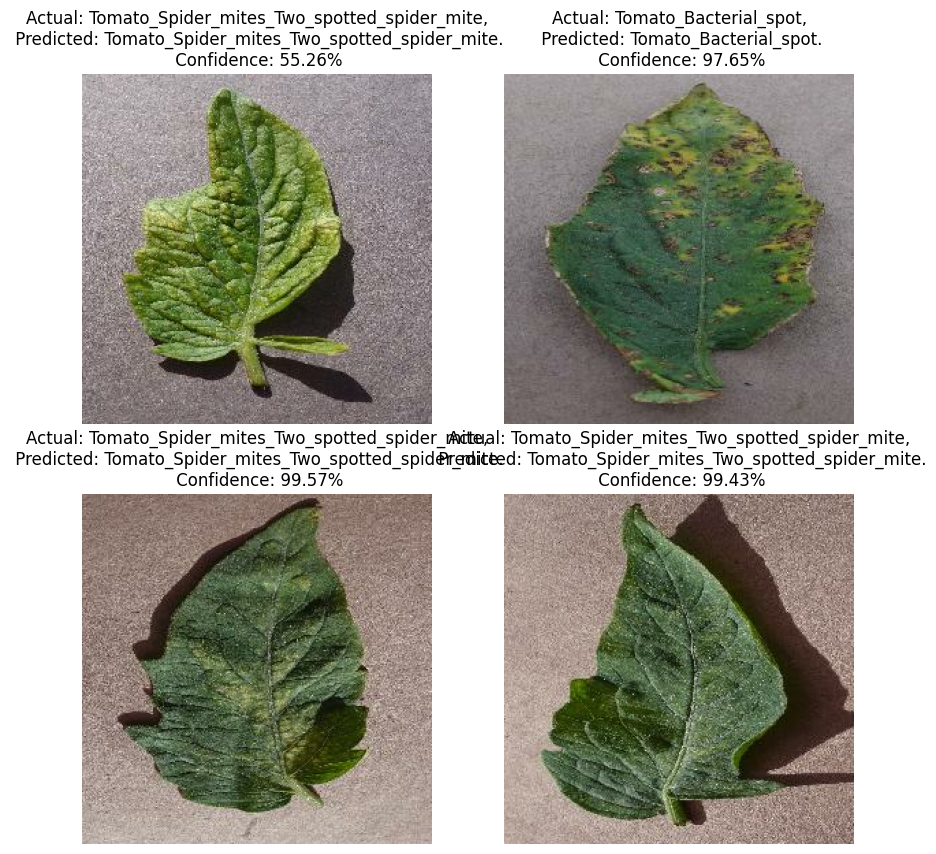

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) #proper image

        predicted_class, confidence = predict(model, images[i].numpy()) #image array with rgb values
        actual_class = types[labels[i]]

        plt.title((f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
saved_model = tf.keras.models.load_model('Downloads/tomatoE5.h5')